# Computing MNIST levelset persistence

One application for topological data analysis is to use persistent homology as a feature for data used in a machine learning task.  We'll look at computing levelset persistence of MNIST data as an example



In [1]:
import bats
import keras
import matplotlib.pyplot as plt
from freudenthal import freudenthal_grid
import time
import numpy as np

In [2]:
from keras.datasets import mnist

In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


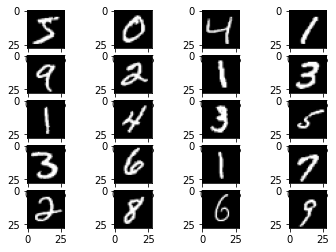

In [4]:
fig = plt.figure()
for i in range(20):  
    
    fig.add_subplot(5,4, 1 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
    
plt.show()

## Compute persistent homology

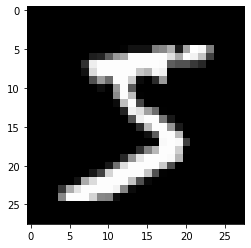

In [5]:
img = train_X[0]
plt.imshow(img, cmap=plt.get_cmap('gray'))

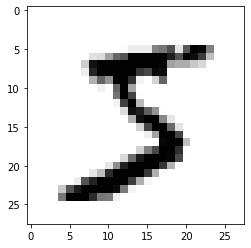

In [6]:
img = 255 - img

plt.imshow(img, cmap=plt.get_cmap('gray'))

In [7]:
m, n = img.shape
X = freudenthal_grid(m, n)

t0 = time.monotonic()
vals, imap = bats.lower_star_filtration(X, img.flatten())
t1 = time.monotonic()
print("time to extend: {} sec.".format(t1 - t0))

t0 = time.monotonic()
F = bats.FilteredSimplicialComplex(X, vals)
t1 = time.monotonic()
print("time to construct: {} sec.".format(t1 - t0))

t0 = time.monotonic()
R = bats.reduce(F, bats.F2())
t1 = time.monotonic()
print("time to reduce: {} sec.".format(t1 - t0))

time to extend: 0.0019052560019190423 sec.
time to construct: 0.002330570998310577 sec.
time to reduce: 0.004491136001888663 sec.


In [1]:
ps = R.persistence_pairs(0, False) +  R.persistence_pairs(1, False)
for p in ps:
    if p.length() > 0:
        print(p)

NameError: name 'R' is not defined

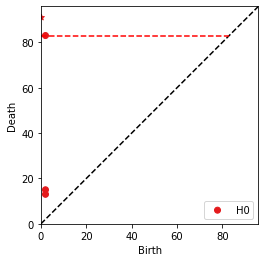

In [9]:
bats.persistence_diagram(ps);

## Timing

option 1: compute everything from scratch each time

In [39]:
from tqdm import tqdm

In [61]:
N = 1000
data = train_X[:N]

text = []
tcon = []
tred = []

for img in tqdm(data):
    irev = 255 - img
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, irev.flatten())
    t1 = time.monotonic()
    text.append(t1 - t0)

    t0 = time.monotonic()
    F = bats.FilteredSimplicialComplex(X, vals)
    t1 = time.monotonic()
    tcon.append(t1 - t0)

    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    tred.append(t1 - t0)

print("extension: {} sec.".format(np.mean(text)))
print("construction: {} sec.".format(np.mean(tcon)))
print("tred: {} sec.".format(np.mean(tred)))
print("avg total: {} sec.".format(np.mean(text) + np.mean(tcon) + np.mean(tred)))

100%|██████████| 1000/1000 [00:05<00:00, 170.86it/s]

extension: 0.0009222199039795669 sec.
construction: 0.0013770034870685777 sec.
tred: 0.003469377200010058 sec.
avg total: 0.005768600591058203 sec.


option 2: update filtration each time

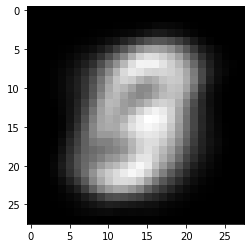

In [86]:
# create an average image
N = 1000
data = train_X[:N]

aimg = np.mean(data, axis=0)
plt.imshow(aimg, cmap=plt.get_cmap('gray'));

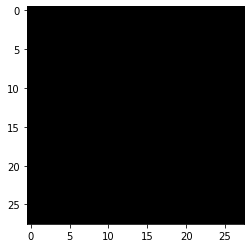

In [88]:
aimg = np.zeros((28,28))
plt.imshow(aimg, cmap=plt.get_cmap('gray'));

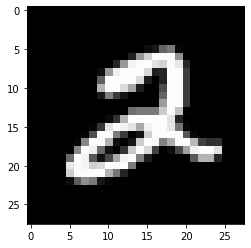

In [84]:
aimg = data[5]
plt.imshow(aimg, cmap=plt.get_cmap('gray'));

In [96]:
np.random.rand?

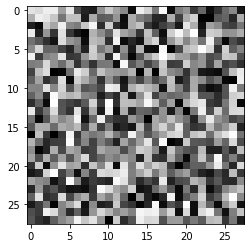

In [97]:
aimg = np.random.rand(28,28)*255
plt.imshow(aimg, cmap=plt.get_cmap('gray'));

In [98]:
text = []
tupd = []

# initialize on average image
irev = 255 - aimg
vals, imap = bats.lower_star_filtration(X, irev.flatten())
F = bats.FilteredSimplicialComplex(X, vals)
R = bats.reduce(F, bats.F2())

for img in tqdm(data):
    irev = 255 - img
    R = bats.reduce(F, bats.F2()) # reduce from scratch
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, irev.flatten())
    t1 = time.monotonic()
    text.append(t1 - t0)

    t0 = time.monotonic()
    R.update_filtration(vals)
    t1 = time.monotonic()
    tupd.append(t1 - t0)

    
print("extension: {} sec.".format(np.mean(text)))
print("update: {} sec.".format(np.mean(tupd)))
print("avg total: {} sec.".format(np.mean(text) + np.mean(tupd)))

100%|██████████| 1000/1000 [00:06<00:00, 145.03it/s]

extension: 0.0010259798880724702 sec.
update: 0.001980408111034194 sec.
avg total: 0.003006387999106664 sec.


In [91]:
for d in range(F.maxdim() + 1):
    print(F.ncells(d))

784
2241
1458


TypeError: ncells(): incompatible function arguments. The following argument types are supported:
    1. (self: bats.libbats.FilteredSimplicialComplex, arg0: int) -> int

Invoked with: <bats.libbats.FilteredSimplicialComplex object at 0x7fb3c45453b0>